In [1]:
import itertools
import os
import pickle
import sys
from pathlib import Path

import cv2
import hdbscan
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import phenograph
import seaborn as sns
import skimage.io
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import DBSCAN, OPTICS, KMeans, cluster_optics_dbscan
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from skimage import measure
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# Import path
module_path = str(Path.cwd().parents[0])
if module_path not in sys.path:
    sys.path.append(module_path)

In [4]:
from config import *

In [5]:
# Parameters
min_cluster_size = 100
min_intensity = 0.3
random_seed = 100

# Read data

In [6]:
pixel_features = data_meta / 'pixel_intensity.csv'  # location of file
df = pd.read_csv(pixel_features)
pixels = df.iloc[:, :11]
display(pixels.max())

# Scale data
scaler = MinMaxScaler()
x_scaled = scaler.fit_transform(pixels)
pixels_scaled = pd.DataFrame(x_scaled, columns=pixels.columns)
display(pixels_scaled.describe())

DAPI                     24117
Phalloidin               61307
WGA                      57667
Concanavadin A           59602
APC                      61245
Cyclin D1                34600
Cyclin E                 54336
EMMPRIN                  60834
WNT-1                    64637
Non-phospho-B-catenin    28759
DKK1                      6677
dtype: int64

,DAPI,Phalloidin,WGA,Concanavadin A,APC,Cyclin D1,Cyclin E,EMMPRIN,WNT-1,Non-phospho-B-catenin,DKK1
count,4.189708e+06,4.189708e+06,4.189708e+06,4.189708e+06,4.189708e+06,4.189708e+06,4.189708e+06,4.189708e+06,4.189708e+06,4.189708e+06,4.189708e+06
mean,5.490950e-02,4.898193e-02,3.293212e-02,4.402110e-02,7.236760e-03,3.255747e-03,1.000895e-02,5.946675e-03,2.468510e-03,2.045527e-02,1.816867e-02
std,1.399681e-01,4.085330e-02,6.341810e-02,9.892625e-02,1.461627e-02,2.681191e-03,2.095746e-02,1.533676e-02,6.028638e-03,2.209952e-02,1.103692e-02
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,2.386085e-02,0.000000e+00,0.000000e+00,1.730754e-03,1.820809e-03,6.257362e-04,1.479436e-03,3.248913e-04,5.737334e-03,1.078329e-02
50%,0.000000e+00,3.779888e-02,4.075121e-03,0.000000e+00,4.702425e-03,3.005780e-03,5.061101e-03,4.043791e-03,1.345978e-03,1.404778e-02,1.722330e-02
75%,0.000000e+00,6.006352e-02,3.678013e-02,4.766619e-02,8.686423e-03,4.335260e-03,1.153931e-02,7.446494e-03,2.722899e-03,2.555722e-02,2.426239e-02
max,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [7]:
pixel_dark = pixels_scaled.le(min_intensity).all(axis=1)
display(pixel_dark.value_counts())
pixels_bright = pixels_scaled[~pixel_dark]
display(pixels_bright.head())

True     3653056
False     536652
dtype: int64

,DAPI,Phalloidin,WGA,Concanavadin A,APC,Cyclin D1,Cyclin E,EMMPRIN,WNT-1,Non-phospho-B-catenin,DKK1
84,0.0,0.042620,0.178248,0.323412,0.000098,0.008439,0.005411,0.004636,0.005229,0.005807,0.010034
85,0.0,0.040777,0.193889,0.335928,0.007641,0.001156,0.015312,0.000444,0.006977,0.000000,0.023064
86,0.0,0.041370,0.204103,0.367488,0.009650,0.000000,0.010730,0.000756,0.005415,0.011162,0.029954
87,0.0,0.050618,0.213970,0.418879,0.007494,0.006705,0.011466,0.001792,0.005399,0.003686,0.022016
88,0.0,0.043213,0.202178,0.405523,0.004213,0.003150,0.021625,0.005573,0.006281,0.000000,0.024113


[6.61957849e-01 1.71446989e-01 8.39674414e-02 3.90140242e-02
 1.82354306e-02 1.16085769e-02 8.02370245e-03 2.65949924e-03
 1.67424874e-03 1.28816947e-03 1.24068455e-04]


Text(0, 0.5, 'explained variance')

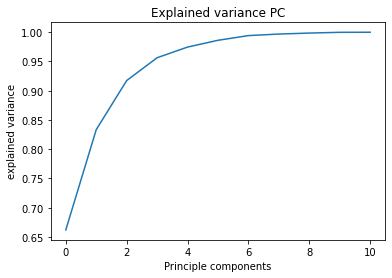

In [8]:
# PCA transformation
pca = PCA()
pca.fit(pixels_bright)
print(pca.explained_variance_ratio_)
X = pca.transform(pixels_bright)

plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.title('Explained variance PC')
plt.xlabel('Principle components')
plt.ylabel('explained variance')


In [11]:
embedding = umap.UMAP(n_neighbors=30,
                      n_components=3,
                      metric='euclidean',
                      init='random').fit_transform(X[:, :5])
embedding.shape

(536652, 3)

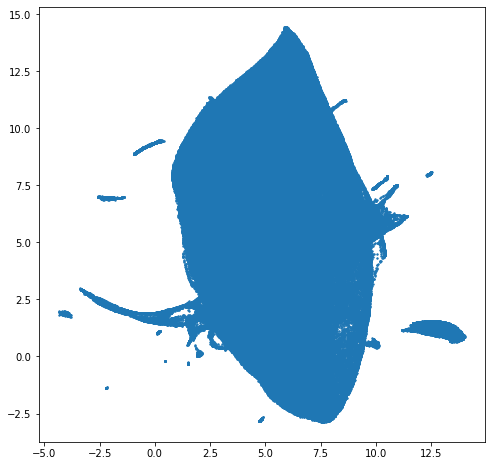

In [12]:
plt.figure(figsize=(8, 8))
plt.scatter(embedding[:,0], embedding[:,1], s=2)

# Clustering

## HDBSCAN

In [13]:
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=min_cluster_size, prediction_data=True)
clusterer.fit(embedding)

HDBSCAN(min_cluster_size=100, prediction_data=True)

In [14]:
np.unique(clusterer.labels_, return_counts=True)

(array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
        16], dtype=int64),
 array([   699,    771,   1539,   6456,    170,    839,    224,    263,
           346,    117,    272,    500,    834, 387615,   3442, 131964,
           284,    317], dtype=int64))

In [15]:
# X = pca.transform(pixels_bright)
# soft_clusters = hdbscan.membership_vector(clusterer, X)

In [16]:
soft_clusters = hdbscan.all_points_membership_vectors(clusterer)

In [17]:
soft_labels = [np.argmax(x) for x in soft_clusters]
np.unique(soft_labels, return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16],
       dtype=int64),
 array([   771,   1539,   6456,    170,    839,    224,    300,    342,
           148,    282,    542,    836, 387738,   3641, 132107,    393,
           324], dtype=int64))

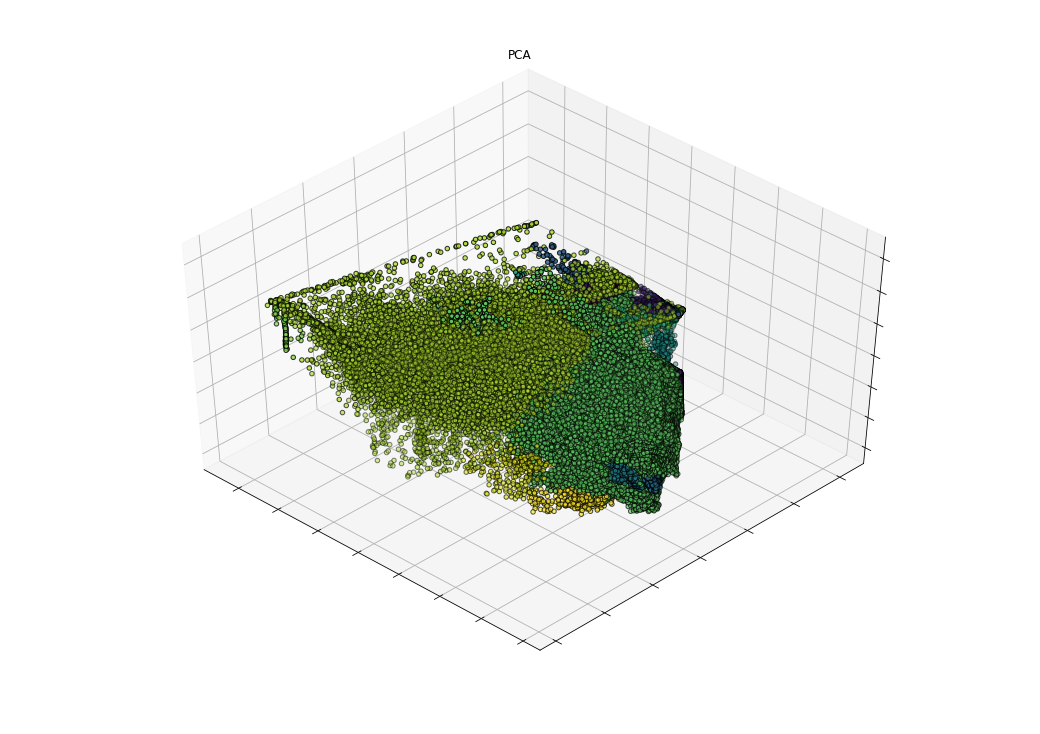

In [18]:
fig = plt.figure(figsize=(15, 10))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)

ax.scatter(X[:, 0], X[:, 1], X[:, 2],
           c=np.array(soft_labels).astype(np.float), edgecolor='k')

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])
ax.set_title('PCA')
ax.dist = 12

In [19]:
pixels_bright.loc[:, 'label'] = np.array(soft_labels) + 1

C:\Users\thu71\.conda\envs\Thomas\lib\site-packages\pandas\core\indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\thu71\.conda\envs\Thomas\lib\site-packages\pandas\core\indexing.py:1048: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


# Visualization


## Cluster visualization of markers expression

In [20]:
# Get dataframe per cluster
df_per_label = pixels_bright.groupby('label').mean()
df_per_label

,DAPI,Phalloidin,WGA,Concanavadin A,APC,Cyclin D1,Cyclin E,EMMPRIN,WNT-1,Non-phospho-B-catenin,DKK1
label,,,,,,,,,,,
1,0.105954,0.070669,0.425826,0.019109,0.004516,0.003752,0.015740,0.009494,0.001149,0.036124,0.017081
2,0.324863,0.013928,0.000962,0.000178,0.006575,0.003001,0.023641,0.007741,0.000290,0.049822,0.012675
3,0.001369,0.362948,0.023363,0.027523,0.011378,0.003281,0.008299,0.004721,0.001975,0.013471,0.018196
4,0.496637,0.009358,0.000000,0.003805,0.002153,0.002303,0.011000,0.004915,0.000120,0.047368,0.011224
5,0.000374,0.043912,0.010365,0.011094,0.416548,0.008459,0.005471,0.008730,0.060973,0.013083,0.028627
6,0.118492,0.052349,0.681336,0.021224,0.004984,0.003765,0.019785,0.013779,0.001363,0.042765,0.017243
7,0.874581,0.087978,0.059783,0.068053,0.013662,0.003981,0.035909,0.010140,0.001147,0.104752,0.022216
8,0.849395,0.127540,0.103331,0.122243,0.012974,0.003731,0.035570,0.013417,0.001506,0.102299,0.022292
9,0.238567,0.025894,0.105047,0.018053,0.006651,0.003346,0.116735,0.655602,0.002359,0.045281,0.013233


[Text(0.5, 0, 'DAPI'),
 Text(1.5, 0, 'Phalloidin'),
 Text(2.5, 0, 'WGA'),
 Text(3.5, 0, 'Concanavadin A'),
 Text(4.5, 0, 'APC'),
 Text(5.5, 0, 'Cyclin D1'),
 Text(6.5, 0, 'Cyclin E'),
 Text(7.5, 0, 'EMMPRIN'),
 Text(8.5, 0, 'WNT-1'),
 Text(9.5, 0, 'Non-phospho-B-catenin'),
 Text(10.5, 0, 'DKK1')]

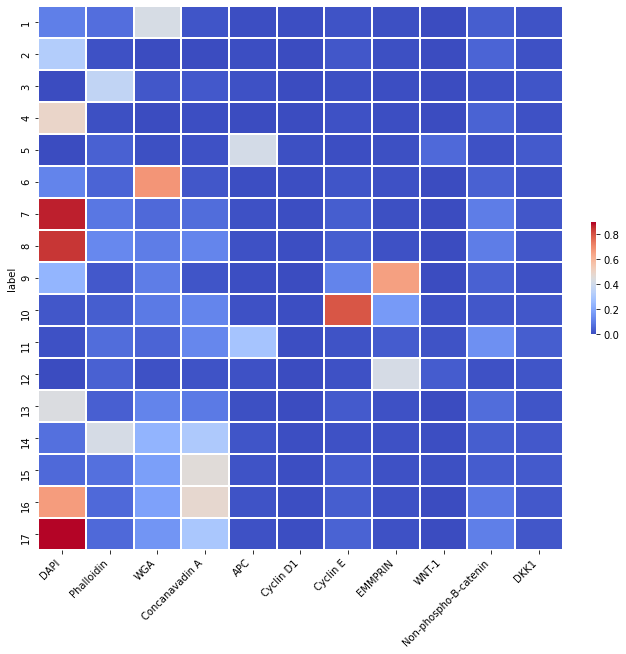

In [25]:
log_norm = LogNorm(vmin=0, vmax=1)

# Plot heat map
fig, ax = plt.subplots(figsize=(10, 10))
ax = sns.heatmap(df_per_label, cbar_kws={
                 'fraction': 0.01}, linewidth=1, cmap="coolwarm")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45,
                   horizontalalignment='right')

Text(669.0000000000001, 0.5, 'Cluster')

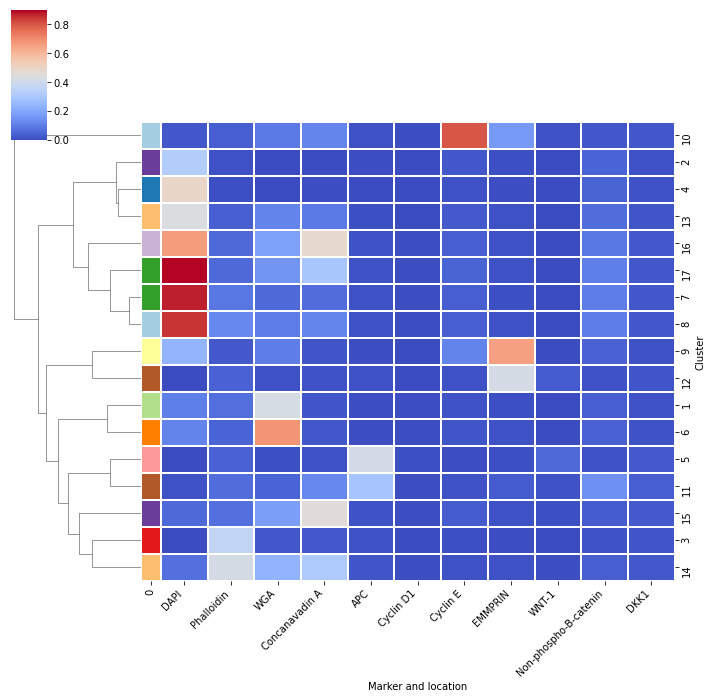

In [39]:
# Get random colormap
vals = np.linspace(0, 1, len(df_per_label))
np.random.seed(random_seed)
np.random.shuffle(vals)
my_cmap = plt.cm.Paired(vals)

# Change to row colors for clustermap
labels = df_per_label.index.to_list()
my_cmap_dict = dict(zip(labels, my_cmap))
row_colors = pd.DataFrame(labels)[0].map(my_cmap_dict)
row_colors.index += 1

# Plot clustermap
ax = sns.clustermap(df_per_label,
                    cbar_kws={'fraction': 0.01},
                    cmap='coolwarm',
                    linewidth=1,
                    row_colors=row_colors,
                    col_cluster=False, 
                    )
ax.ax_heatmap.set_xticklabels(
ax.ax_heatmap.get_xticklabels(), rotation=45, horizontalalignment='right')
ax.ax_heatmap.set_xlabel('Marker and location')
ax.ax_heatmap.set_ylabel('Cluster')

Text(669.0000000000001, 0.5, 'Cluster')

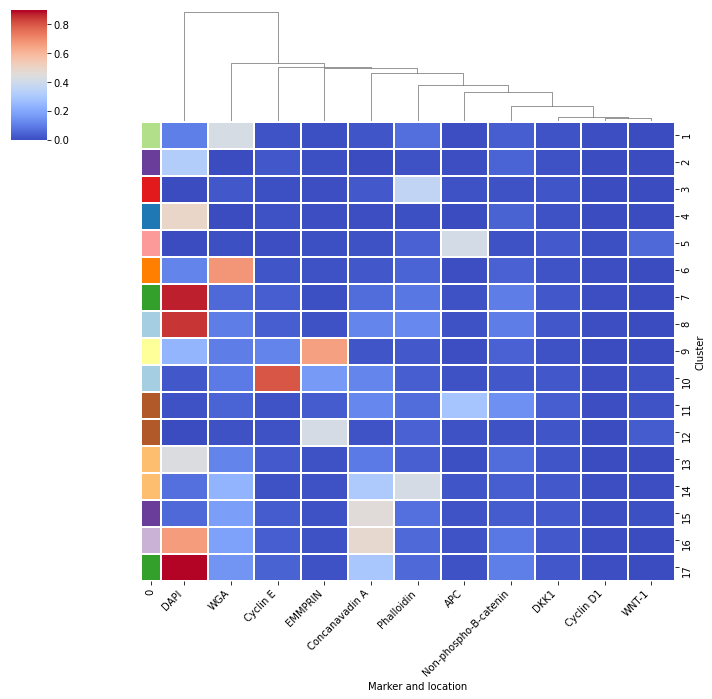

In [40]:
# Plot clustermap
ax = sns.clustermap(df_per_label,
                    cbar_kws={'fraction': 0.01},
                    cmap='coolwarm',
                    linewidth=1,
                    row_colors=row_colors,
                    row_cluster=False, 
                    )
ax.ax_heatmap.set_xticklabels(
ax.ax_heatmap.get_xticklabels(), rotation=45, horizontalalignment='right')
ax.ax_heatmap.set_xlabel('Marker and location')
ax.ax_heatmap.set_ylabel('Cluster')

## Pixel location visualization

First we add back the location and condition information in the pixel_bright dataframe

In [41]:
pixels_bright = pixels_bright.join(df.iloc[:, 11:])
pixels_bright.head()

,DAPI,Phalloidin,WGA,Concanavadin A,APC,Cyclin D1,Cyclin E,EMMPRIN,WNT-1,Non-phospho-B-catenin,DKK1,label,Condition,X,Y,Id
84,0.0,0.042620,0.178248,0.323412,0.000098,0.008439,0.005411,0.004636,0.005229,0.005807,0.010034,15,Fw1,0,612,4
85,0.0,0.040777,0.193889,0.335928,0.007641,0.001156,0.015312,0.000444,0.006977,0.000000,0.023064,15,Fw1,0,613,4
86,0.0,0.041370,0.204103,0.367488,0.009650,0.000000,0.010730,0.000756,0.005415,0.011162,0.029954,15,Fw1,0,614,4
87,0.0,0.050618,0.213970,0.418879,0.007494,0.006705,0.011466,0.001792,0.005399,0.003686,0.022016,15,Fw1,0,615,4
88,0.0,0.043213,0.202178,0.405523,0.004213,0.003150,0.021625,0.005573,0.006281,0.000000,0.024113,15,Fw1,0,616,4


In [42]:
condition = 'Fw1'
df_subset = pixels_bright[pixels_bright.Condition == condition]

In [43]:
# Read mask image
def get_masks(mask_folder):
    '''
    Function to get all mask from mask forlder
    '''
    # Read masks
    masks = {}

    for (dirpath, dirnames, filenames) in os.walk(mask_folder):
        for name in sorted(filenames):
            if "tiff" in name:
                condition = name.split("_")[0]
                masks[condition] = masks.get(condition, {})
                filename = os.path.join(dirpath, name)
            if "cyto" in name:
                img = skimage.io.imread(filename)
                masks[condition]["cyto"] = img
            elif "nuclei" in name:
                img = skimage.io.imread(filename)
                masks[condition]["nuclei"] = img
    return masks


def qc_nuclei(mask_cyto, mask_nuclei):
    '''
    Function to check if cell masks contain nuclei
    '''
    cell = np.zeros((mask_cyto.shape), dtype=np.uint8)
    nuclei = np.zeros((mask_cyto.shape), dtype=np.uint8)
    cyto = np.zeros((mask_cyto.shape), dtype=np.uint8)

    for label in range(1, mask_cyto.max()):
        # Check if cell has nuclei
        cell_mask = np.where(mask_cyto == label, 1, 0).astype(np.uint8)
        maski = cv2.bitwise_and(mask_nuclei, mask_nuclei, mask=cell_mask)

        # If no nuclei detected then pass
        if maski.max() == 0:
            continue

        # Link label accross cell, nuclei, cyto
        cell = np.where(mask_cyto == label, label, cell)
        nuclei = np.where(maski > 0, label, nuclei)
        maski = cv2.subtract(cell_mask, maski)
        cyto = np.where(maski > 0, label, cyto)
    return cell, nuclei, cyto


masks = get_masks(data_mask)
mask, mask_nuclei, _ = qc_nuclei(masks[condition]['cyto'], masks[condition]['nuclei'])
mask_binary = np.where(mask > 0, 1, 0)

In [44]:
# Create image from pixel location
x_max, y_max = mask.shape

x = df_subset.X.tolist()
y = df_subset.Y.tolist()
values = df_subset.label.tolist()

img = np.zeros((x_max, y_max))
img[x, y] = values

In [45]:
# Get contour of masks
contours = {}
contours_nuclei = {}
labels = [n for n in np.unique(mask) if n > 0]
for i in labels:
    temp = np.where(mask == i, mask, 0)
    contours[i] = measure.find_contours(temp, 0.1)[0]
    temp = np.where(mask_nuclei == i, mask, 0)
    contours_nuclei[i] = measure.find_contours(temp, 0.1)[0]

(-0.5, 1874.5, 1415.5, -0.5)

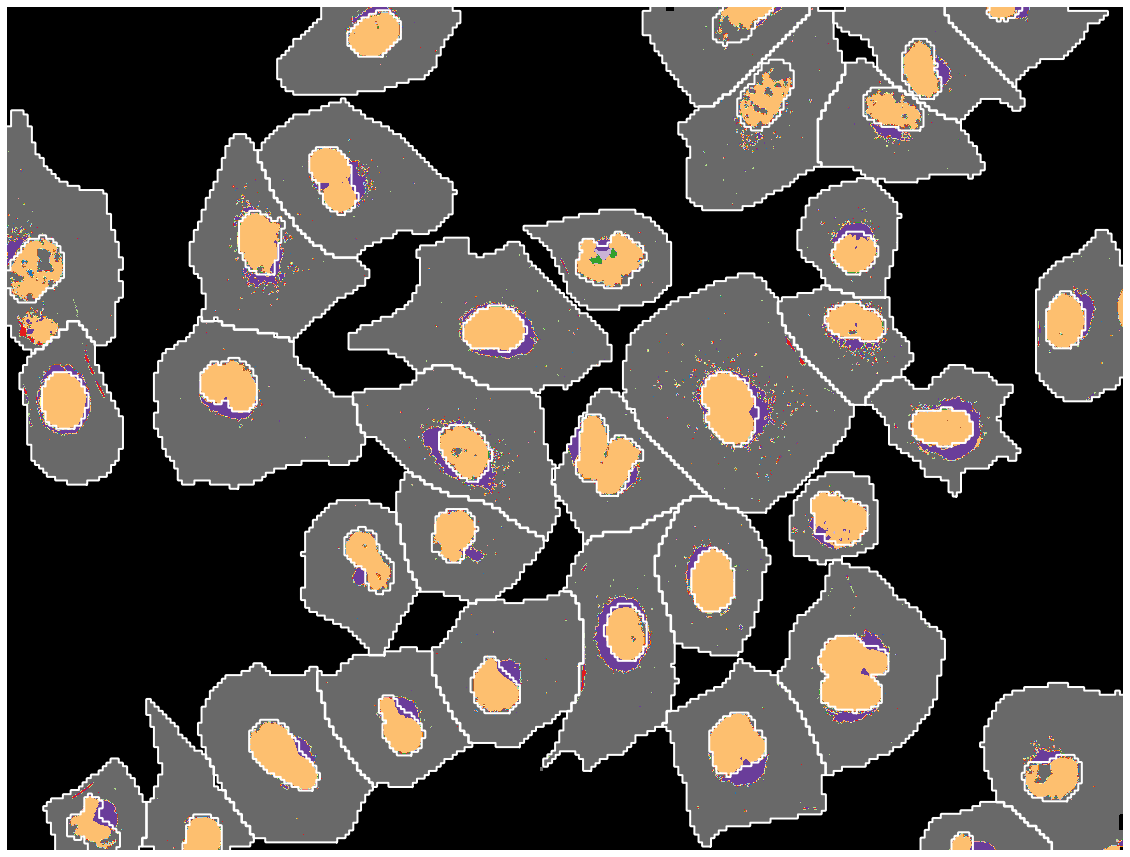

In [46]:
# Get random colormap
bg_color = np.array([[0, 0, 0, 0]])
colors = np.concatenate((bg_color, my_cmap))
my_cmap_bg = plt.cm.colors.ListedColormap(colors)
my_cmap_binary = plt.cm.colors.ListedColormap(['k', 'dimgray'])

# Show contour
fig, ax = plt.subplots(figsize=(20, 20))
ax.imshow(mask_binary, cmap=my_cmap_binary)
ax.imshow(img, cmap=my_cmap_bg)
for label, contour in contours.items():
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2, c='w')
    ax.plot(contours_nuclei[label][:, 1],
            contours_nuclei[label][:, 0], linewidth=2, c='w')
ax.axis('off')

(<mpl_toolkits.axes_grid1.inset_locator.BboxPatch at 0x20cacfab7b8>,
 <mpl_toolkits.axes_grid1.inset_locator.BboxConnector at 0x20ce37cf240>)

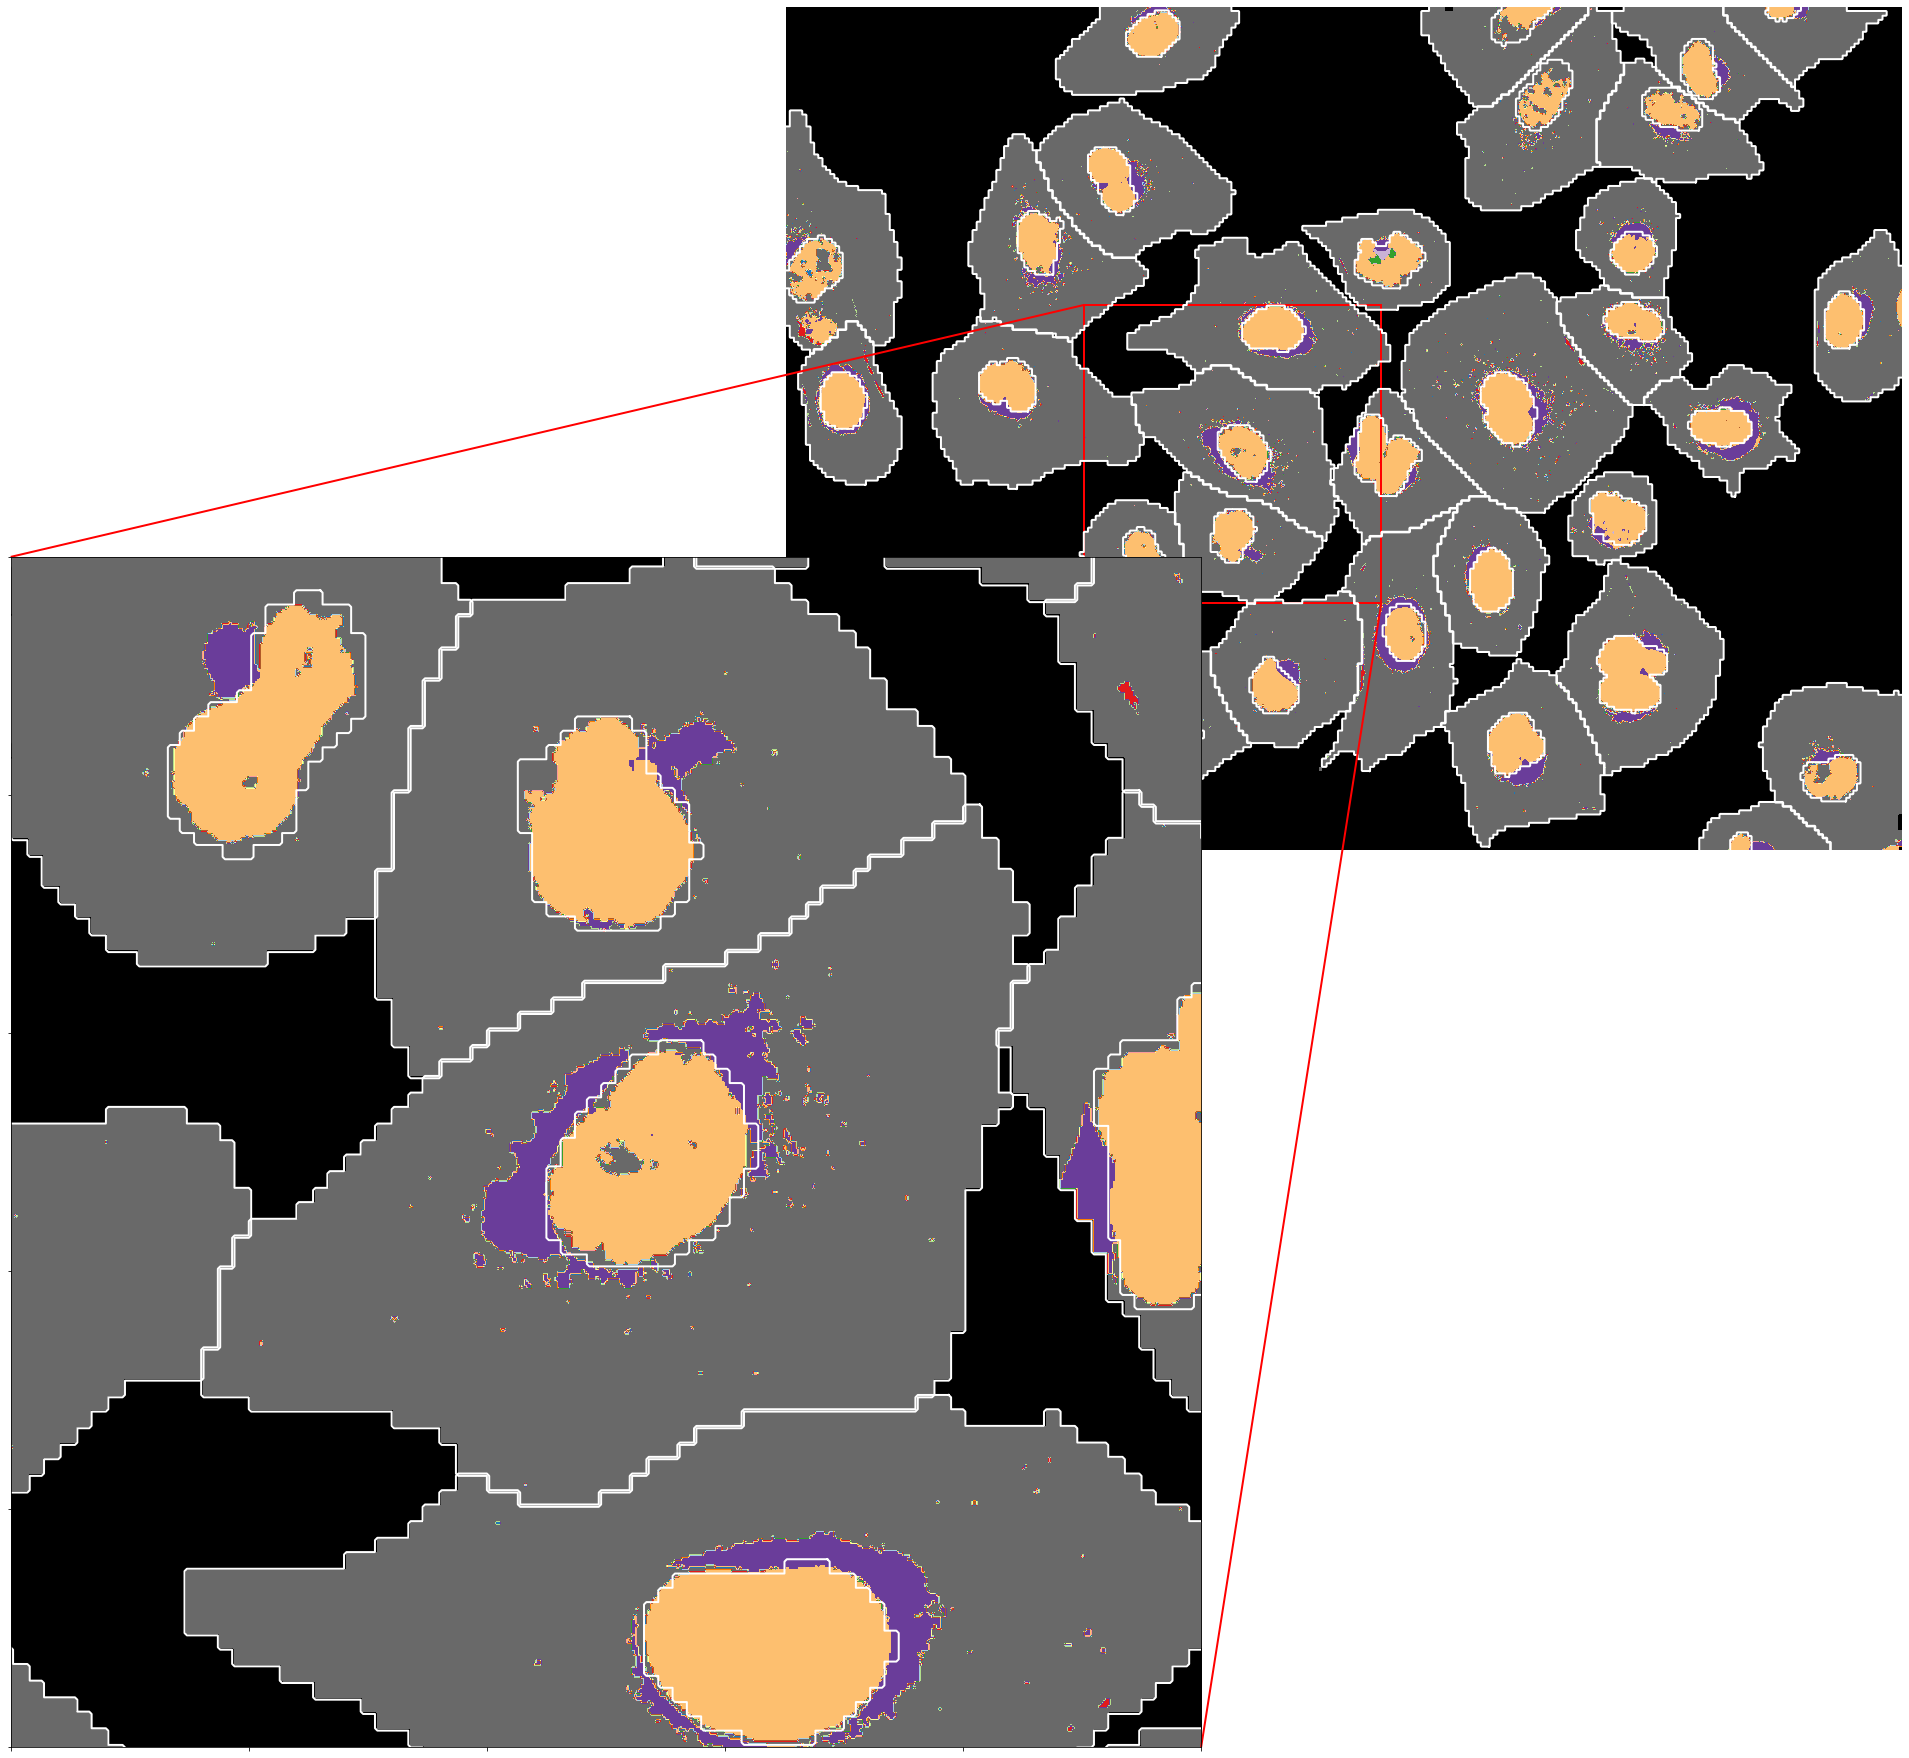

In [47]:
# Get random colormap
bg_color = np.array([[0, 0, 0, 0]])
colors = np.concatenate((bg_color, my_cmap))
my_cmap_bg = plt.cm.colors.ListedColormap(colors)
my_cmap_binary = plt.cm.colors.ListedColormap(['k', 'dimgray'])

# Show contour
fig, ax = plt.subplots(figsize=(20, 20))
ax.imshow(mask_binary, cmap=my_cmap_binary)
ax.imshow(img, cmap=my_cmap_bg)
for label, contour in contours.items():
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2, c='w')
    ax.plot(contours_nuclei[label][:, 1],
            contours_nuclei[label][:, 0], linewidth=2, c='w')
ax.axis('off')

axins = zoomed_inset_axes(ax, 4, loc='center', bbox_to_anchor=(0,0))
axins.imshow(mask_binary, cmap=my_cmap_binary)
axins.imshow(img, cmap=my_cmap_bg)
for label, contour in contours.items():
    axins.plot(contour[:, 1], contour[:, 0], linewidth=2, c='w')
    axins.plot(contours_nuclei[label][:, 1],
            contours_nuclei[label][:, 0], linewidth=2, c='w')
axins.set_xlim(500, 1000)
axins.set_ylim(500, 1000)
plt.xticks(visible=False)
plt.yticks(visible=False)
mark_inset(ax, axins, loc1=2, loc2=4, fc="none", lw=2, ec="r")